<div style="border:5px solid #d3d3d3; border-radius:12px; text-align:center; padding:30px; background: linear-gradient(to right, #e0f7fa, #cce0ff); box-shadow: 2px 2px 12px rgba(0,0,0,0.1); font-family: 'Segoe UI', sans-serif;">
  <h1 style="font-weight:bold; color:#005577;"> Predicting Used Car Prices Using Regression Analysis</h1>
</div>


<br></br>

### Installing required libraries

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st
import statsmodels.api as sm
import statsmodels.graphics.gofplots as smg

from statsmodels.formula.api import ols
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

In [2]:
# Google Drive file ID 
file_id = '1jXjE9E6XHW9vlKGL8ZdG4jm-AzXW0chO'

# Construct URL
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Load data
df = pd.read_csv(url)
df.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,Fiesta,2017,Automatic,15944,Petrol,150.0,57.7,1.0,12000
1,Focus,2018,Manual,9083,Petrol,150.0,57.7,1.0,14000
2,Focus,2017,Manual,12456,Petrol,150.0,57.7,1.0,13000
3,Fiesta,2019,Manual,10460,Petrol,145.0,40.3,1.5,17500
4,Fiesta,2019,Automatic,1482,Petrol,145.0,48.7,1.0,16500


In [3]:
# Dataset size
print(df.shape)

(17966, 9)


------------------------------------------


## Data Cleaning

In [4]:
# Identifying columns with missing values
missing_values = df.isnull().sum()
print("Columns with missing values:\n", missing_values)

Columns with missing values:
 model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             3
mpg             0
engineSize      0
price           0
dtype: int64


In [5]:
# fill missing values with the mean
df['tax'] = df['tax'].fillna(df['tax'].mean())

In [6]:
# Re-check missing values
print(df.isnull().sum())
print()
print('Data Cleaning Successfull!')

model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
price           0
dtype: int64

Data Cleaning Successfull!


In [7]:
# Glimpse of summary statistics (without the column 'year')
print('Summary Statistics:\n', df.drop(columns=['year']).describe().round(2))

Summary Statistics:
          mileage       tax       mpg  engineSize     price
count   17966.00  17966.00  17966.00    17966.00  17966.00
mean    23362.61    113.33     57.91        1.35  12279.53
std     19472.05     62.01     10.13        0.43   4741.34
min         1.00      0.00     20.80        0.00    495.00
25%      9987.00     30.00     52.30        1.00   8999.00
50%     18242.50    145.00     58.90        1.20  11291.00
75%     31060.00    145.00     65.70        1.50  15299.00
max    177644.00    580.00    201.80        5.00  54995.00


#### Mileage
Approximately 23,38 miles on average is the typical vehicle usage, and the range is 1.00 to 177644 miles. High-mileage vehicles likely sell for lower prices, while lower-mileage cars may demand a premium. 25% of the cars are at 10000 miles, which is normal since the data is about used cars.

#### Tax
The mean tax is 113 dollars and varies from 0 to 500 dollars. 25% of cars have taxes below 30, while 75% are taxed at $145. The variation might be explained by tax exemption for certain vehicles, or a tax policy based on fuel emissions. The lower the tax costs, the better it will be for buyers with constrained budgets.

#### MPG
The mean MPG is approximately 57.9 miles per gallon, with a range of  20.8 to 201.8 MPG, suggesting that some vehicles are extremely fuel-efficient. Cars with higher MPG (especially hybrids/electric) could be more appealing for buyers when fuel prices go up.
 
#### Engine Size
The mean of engine size is 1.35 liters, and the range is 0.0 to 5.0 liters. The 0.0 liters indicate the use of electric engines. 50% of cars have engines less than or equal to 1.2 liters, indicating that more compact models dominate the market. Larger engine vehicles, those greater or equal to 1.5 liters, suggest higher performance and are thus to be premium models.

#### Price
The mean price is  12,269 dollars, and the range is 495 - 54,995 dollars. This large disparity might be due to different car conditions, brands, and features. 25% of vehicles, when the price is less than or equal to 8,999 dollars, suggest cheaper purchases. 75% of vehicles, when the price is greater than or equal to $15,295, indicate the premium models in the market. Being top of the quartile, the premium model dominates the lower price range.


---

# Exploratory Data Analysis

#### Correlation Matrix

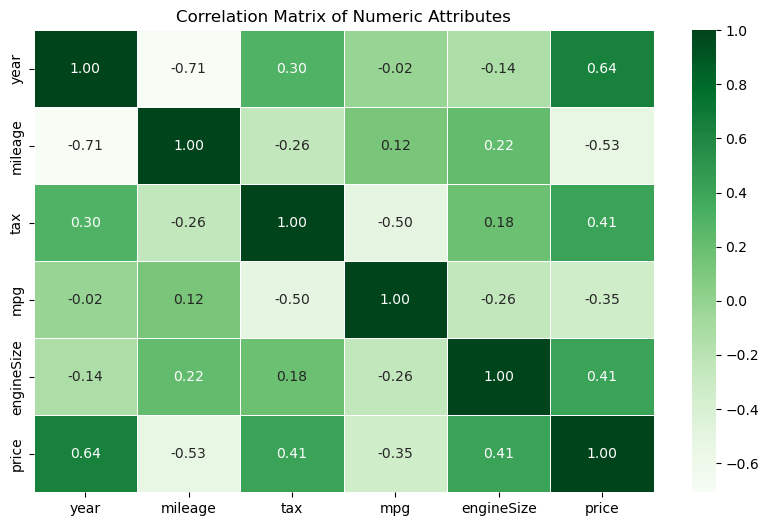

In [8]:
# Compute correlation matrix with only numerical colunms
numeric_cols = df.select_dtypes(include='number').columns
correlation_matrix = df[numeric_cols].corr()

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Greens", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Attributes")
plt.show()


The data indicates that year is the highest correlated feature with price. The more recent a used car is, the higher its price is.

<br></br>

### Histogram

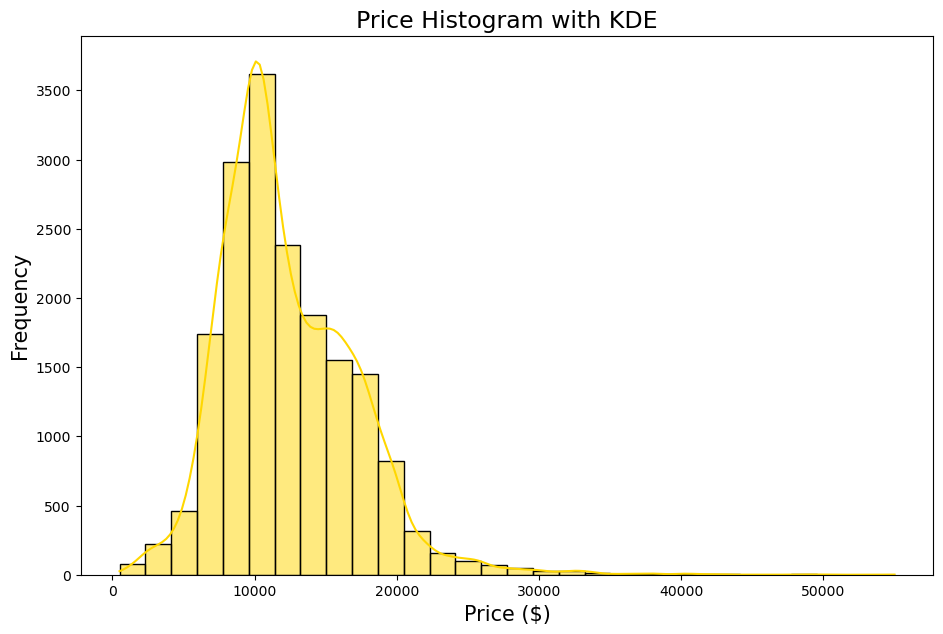

In [9]:
plt.figure(figsize=(11,7))
sns.histplot(x=df['price'], bins=30, kde=True, color='gold', edgecolor='black')
plt.title('Price Histogram with KDE', fontsize=17)
plt.xlabel('Price ($)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

#### Comments

1. The distribution of prices is not perfectly normal as it shows signs of right skewness.
1. Most of the vehicles are priced between 5,000 and 15,000 dollars, which suggests that the majority of sold cars fall into the mid-range affordability zone.
3. The skew reflects real-world market behavior: most buyers aim for affordability

<br></br>

### Box plot 

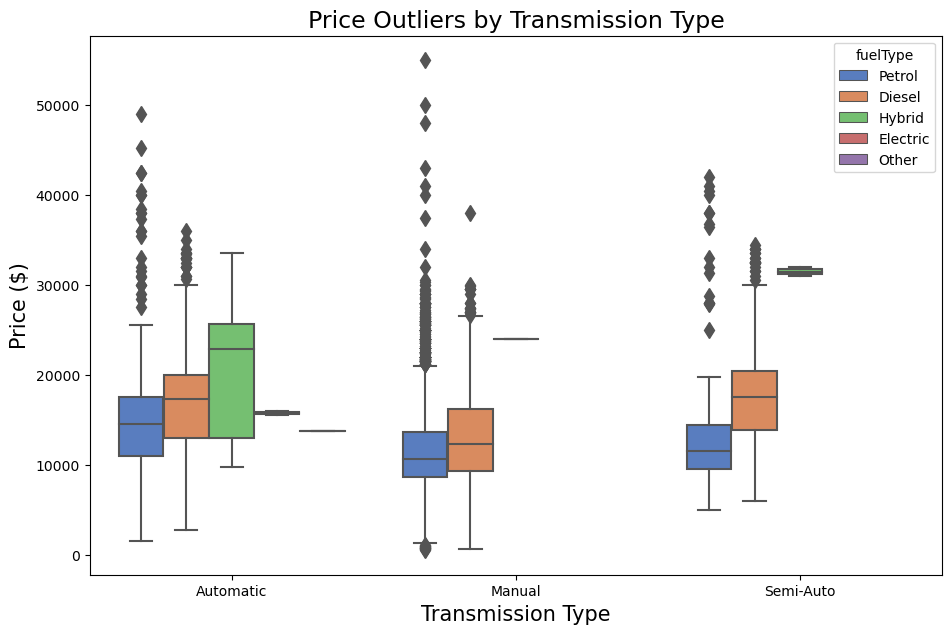

In [10]:
# Create a box plot for transmission vs. price
plt.figure(figsize=(11, 7))
sns.boxplot(x=df["transmission"], y=df["price"], palette='muted',
            fliersize=8, width=0.8, hue='fuelType', data=df)
plt.title("Price Outliers by Transmission Type", fontsize=17)
plt.xlabel("Transmission Type", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.show()

The boxplot suggests that manual transmission vehicles have more price outliers compared to semi-auto and automatic cars. However, automatic transmissions tend to have higher prices on average.

<br></br>

### Bar Charts

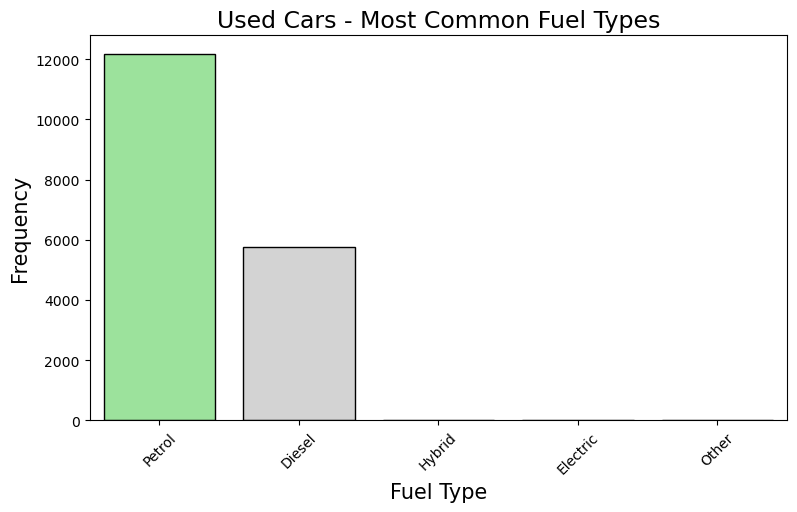

In [11]:
# Counting the fuelType feature
column_name = "fuelType" 
fuel_num = df[column_name].value_counts()

# To determine the highest count 
highest_fuel_type = fuel_num.idxmax()

#Color palette
colors = ['lightgreen' if fuel==highest_fuel_type else 'lightgrey' for fuel in fuel_num.index.tolist()]

# Creating the bar chart
plt.figure(figsize=(9,5))
sns.barplot(x=fuel_num.index, y=fuel_num.values, palette= colors,edgecolor='black')
plt.title('Used Cars - Most Common Fuel Types', fontsize=17)
plt.xlabel('Fuel Type', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Frequency', fontsize=15)
plt.show()

Based on this bar chart, dealerships should primarily focus on selling Petrol and Diesel cars. Nevertheless, the instant fuel prices increase, used car buyers could have more incentive to purchase Electric/Hybrid cars.

<br></br>

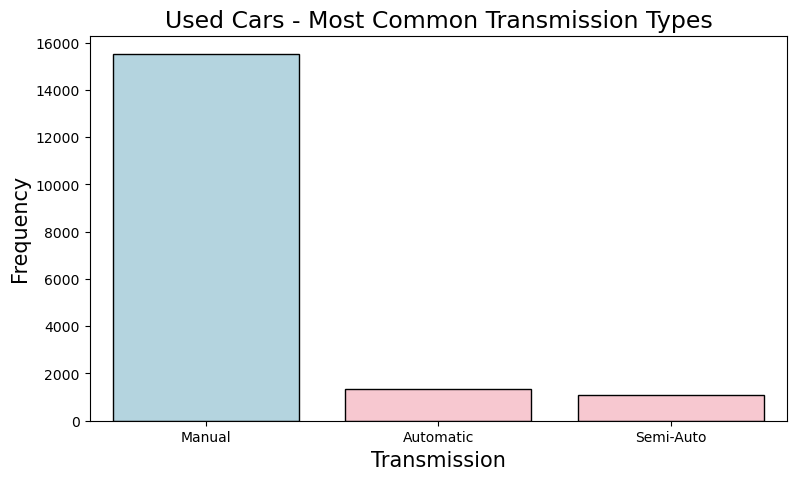

In [12]:
# Counting the occurrences of each unique value
value_counts2 = df['transmission'].value_counts()

# To determine the highest transmission type
highest_transm_count = value_counts2.idxmax()

# Creating color palette
colors2 = ['lightblue' if transm== highest_transm_count else 'pink' for transm in value_counts2.index]

# Creating bar plot
plt.figure(figsize=(9,5))
sns.barplot(x=value_counts2.index, y=value_counts2.values, palette= colors2,edgecolor='black')
plt.title('Used Cars - Most Common Transmission Types', fontsize=17)
plt.xlabel('Transmission', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()


1. The vast majority of used cars are manual, indicating that either manual cars are more widely available or they are preferred in the used car market.

2. Automatic cars are significantly less common in used car markets, likely because they are often more expensive, which could also impact their affordability.

3. Semi-Auto cars are the least common in the used car market because they are considered to be unique variants. Consequently, they will appeal to a smaller portion of buyers due to their specific functionality.

<br></br>

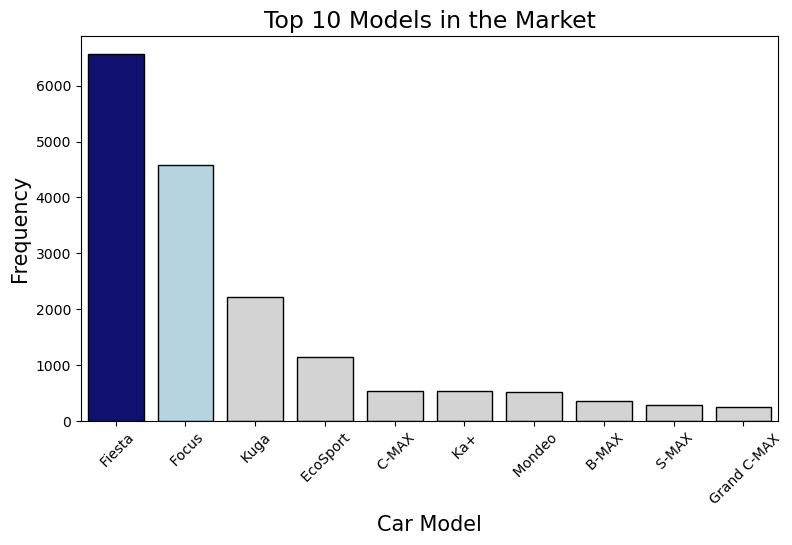

In [13]:
# Showing the top 10 used car models
top_10_models = df['model'].value_counts().head(10)

highest_model = top_10_models.idxmax()
second_highest_model = top_10_models.index[1]
third_highest_model = top_10_models.index[2]
colors3 = ['navy' if model == highest_model else 'lightblue' if model == second_highest_model else 'lightgrey' for model in top_10_models.index]

# Histogram showing top 10 models
plt.figure(figsize=(9, 5))
sns.barplot(x=top_10_models.index, y=top_10_models.values, palette=colors3, edgecolor='black')
plt.title("Top 10 Models in the Market", fontsize=17)
plt.xticks(rotation=45)
plt.xlabel("Car Model", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()

#### Comments : 
1. It is noticeable that the Fiesta and Focus models - *Both Compact models* - are favored in the market, likely for their efficiency. Kuga and EcoSport - *Both SUVs* - have a decent market presence, likely chosen for versatility. 
2. The difference between the other models is significant. Luxury and larger family models (Mondeo, C-MAX, etc.) exist but in smaller numbers, serving specific buyer segments.

<br></br>

### Regression Plots 

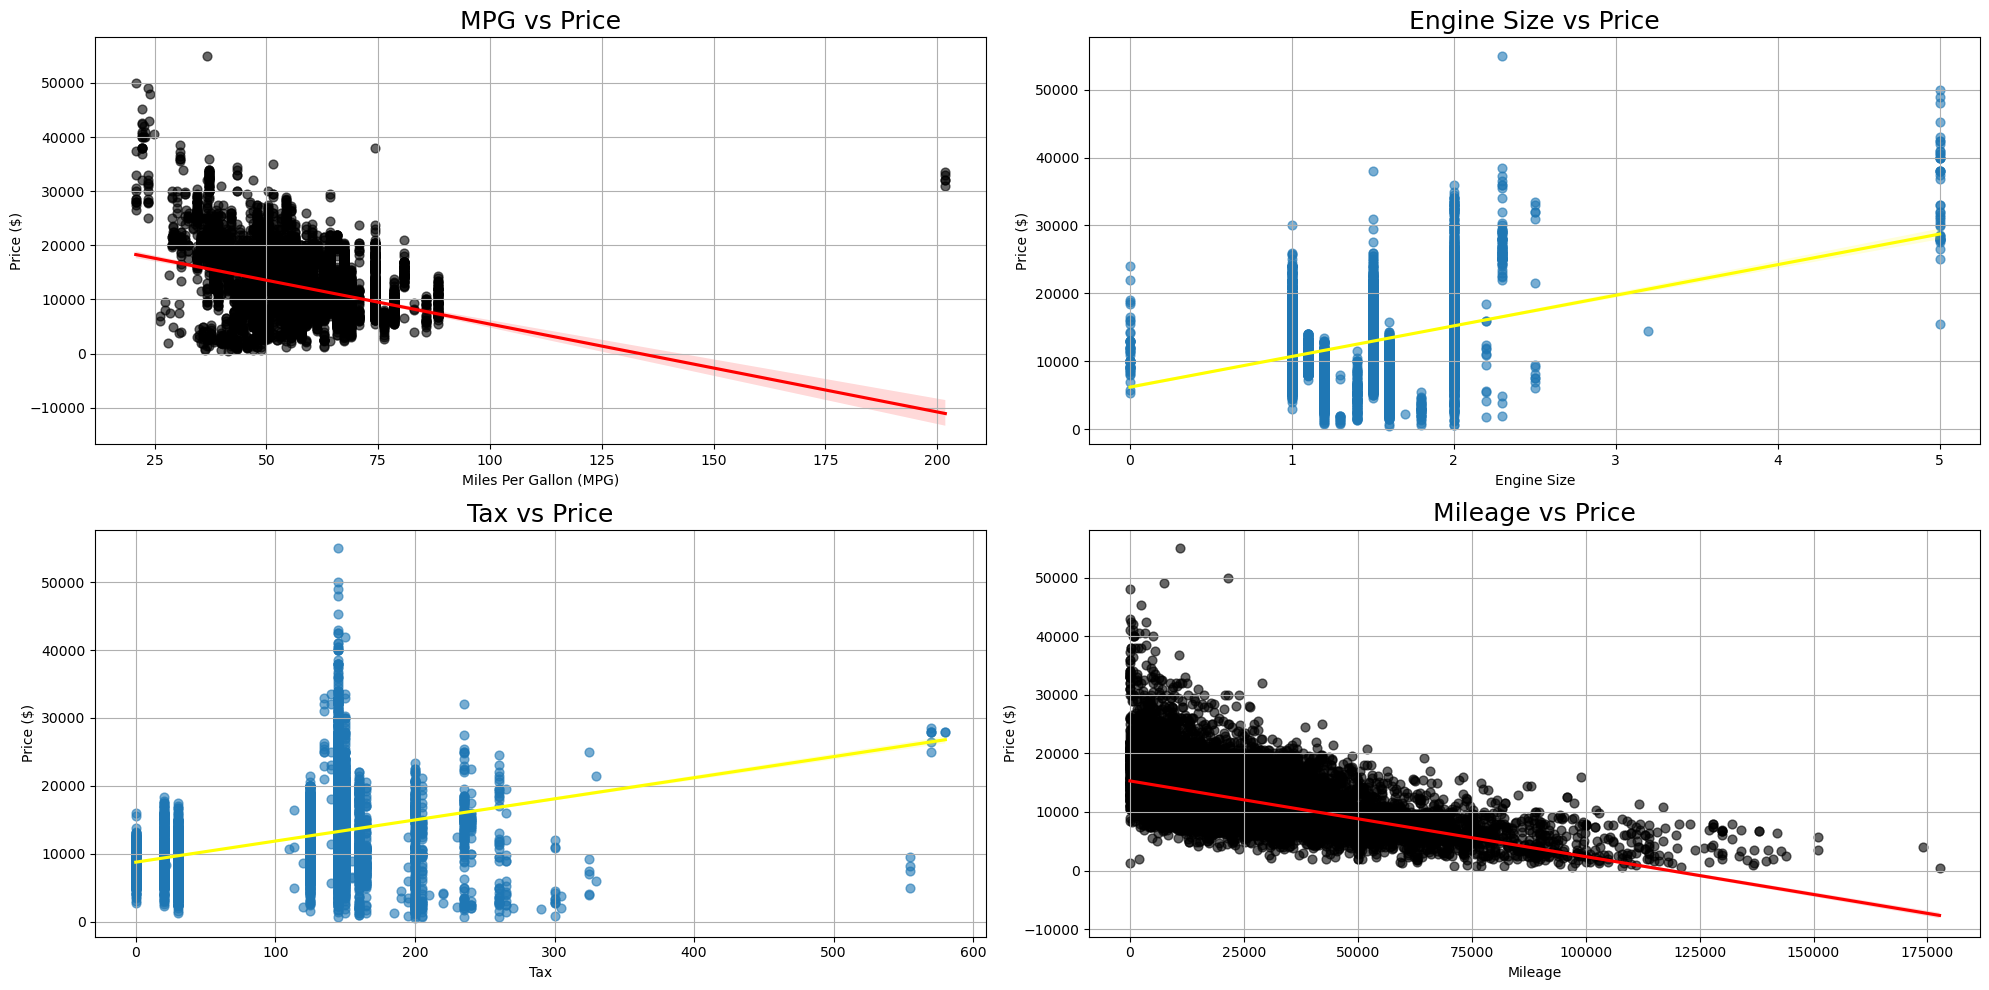

In [14]:
# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# MPG vs Price
sns.regplot(x='mpg', y='price', data=df,scatter_kws={'color': 'black', 's': 40, 'alpha': 0.6},
            line_kws={'color': 'red'},
            ax=axes[0, 0])
axes[0, 0].set_title('MPG vs Price', fontsize=18)
axes[0, 0].set_xlabel('Miles Per Gallon (MPG)')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True)

# Engine Size vs Price
sns.regplot(x='engineSize', y='price', data=df, scatter_kws={ 's': 40, 'alpha': 0.6},
            line_kws={'color': 'yellow'},
            ax=axes[0, 1])
axes[0, 1].set_title('Engine Size vs Price', fontsize=18)
axes[0, 1].set_xlabel('Engine Size')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].grid(True)

# Tax vs Price
sns.regplot(x='tax', y='price', data=df,scatter_kws={'s': 40, 'alpha': 0.6},
            line_kws={'color': 'yellow'},
            ax=axes[1, 0])
axes[1, 0].set_title('Tax vs Price', fontsize=18)
axes[1, 0].set_xlabel('Tax')
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].grid(True)

# Mileage vs Price
sns.regplot(x='mileage', y='price', data=df,scatter_kws={'color':'black','s': 40, 'alpha': 0.6},
            line_kws={'color': 'red'},
            ax=axes[1, 1])
axes[1, 1].set_title('Mileage vs Price', fontsize=18)
axes[1, 1].set_xlabel('Mileage')
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Get the current year
current_year = datetime.now().year

# Create car_age feature to handle scaling issues
df['car_age'] = current_year - df['year']

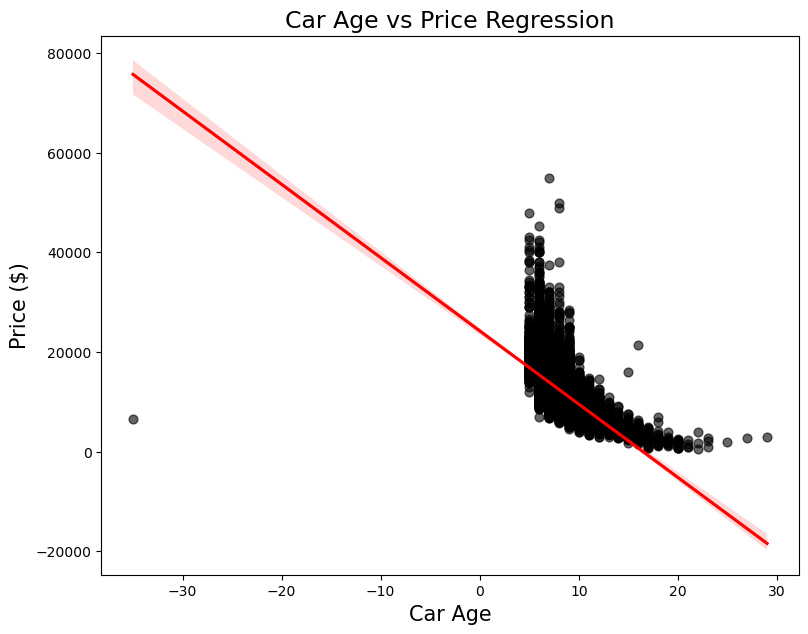

In [16]:
# Regression plot car age vs price 
plt.figure(figsize=(9,7))
sns.regplot(x='car_age', y='price', data=df,scatter_kws={'color':'black','s': 40, 'alpha': 0.6},
            line_kws={'color': 'red'})
plt.title("Car Age vs Price Regression", fontsize=17)
plt.xlabel("Car Age", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.show()

On average, the older a used car is, the lower its market price tends to be.

---

# Hypothesis Development for Price Prediction Model

In [17]:
# Pearson correlation (linear relationship)
r_mileage, p_mileage = pearsonr(df['mileage'], df['price'])
r_year, p_year = pearsonr(df['year'], df['price'])
r_engine, p_engine = pearsonr(df['engineSize'], df['price'])
r_tax, p_tax = pearsonr(df['tax'], df['price'])

print(f"Pearson Correlation (Tax vs Price): r = {r_tax:.3f}, p = {p_tax:.3f}")
print()
print(f"Pearson Correlation (Engine Size vs Price): r = {r_engine:.3f}, p = {p_engine:.3f}")
print()
print(f"Pearson correlation (Mileage vs Price): r = {r_mileage:.3f}, p = {p_mileage:.3f}")
print()
print(f"Pearson correlation (Year vs Price): r = {r_year:.3f}, p = {p_year:.3f}")

Pearson Correlation (Tax vs Price): r = 0.407, p = 0.000

Pearson Correlation (Engine Size vs Price): r = 0.411, p = 0.000

Pearson correlation (Mileage vs Price): r = -0.531, p = 0.000

Pearson correlation (Year vs Price): r = 0.636, p = 0.000


All selected features are statistically correlated with the price of used cars.

<br></br>

### Hypothesis: Cars under 5 years old have higher prices.

1. H0: There is no significant difference in average price between cars that are 5 years old or younger and those older than 5 years. `Mu_new_cars <= Mu_old_cars`

2. H1: Cars that are 5 years old or younger have a higher average price than older cars.`Mu_new_cars > Mu_old_cars`

In [18]:
# Create young and old cars
young = df[df['car_age'] <= 5]['price']
old = df[df['car_age'] > 5]['price']

# t-test
t_stat, p_val = ttest_ind(young, old)
print(f"T-test: t = {t_stat:.2f}, p = {p_val:.4f}")

T-test: t = 29.71, p = 0.0000


There is enough evidence to reject the Null hypothesis. As expected, used cars under five years old tend to be more expensive on average.

<br></br>

### Hypothesis: Cars with larger engines (≥ 1.5L) have higher prices.

1. H0: There is no significant difference in average price between cars that are 5 years old or younger and those older than 5 years. `Mu_small_engine <= Mu_large_engine`

2. H1: Cars that are 5 years old or younger have a higher average price than older cars.`Mu_small_engine > Mu_large_engine`

In [19]:
# Create small and large engine size
small = df[df['engineSize'] < 1.5]['price']
large = df[df['engineSize'] >= 1.5]['price']

# t-test
t_stat, p_val = ttest_ind(small, large)
print(f"T-test: t = {t_stat:.2f}, p = {p_val:.4f}")

T-test: t = -43.19, p = 0.0000


Turns out, there is enough evidence to say that the average price of small engines tends to be higher than larger engines, likely due to smaller engines strong association with high-end specs.

<br></br>

### Hypothesis: Cars taxed above $150 have higher prices.

1. H0: There is no difference or high-tax cars do not have higher prices than low-tax cars. `Mu_high_tax <= Mu_low_tax` 

2. H1: Cars taxed above 150 have higher average prices than those taxed at $150 or below.`Mu_high_tax > Mu_low_tax`

In [20]:
# Create low and high tax cars
low_tax = df[df['tax'] <= 150]['price']
high_tax = df[df['tax'] > 150]['price']

# t-test
t_stat, p_val = ttest_ind(low_tax, high_tax)
print(f"T-test: t = {t_stat:.2f}, p = {p_val:.4f}")

T-test: t = 9.23, p = 0.0000


While both new and old cars in general are subject to the same tax rate of 6%, the total amount of sales tax tends to be lower on used cars. And, there is enough evidence to arrive at this conclusion.

<br></br>

### Hypothesis: do price differs significantly across categories ('fuelType' and 'transmission')

In [23]:
# Compare price across fuel types
grouped = [group['price'].values for name, group in df.groupby('fuelType')]
f_stat, p_val = f_oneway(*grouped)

print(f"ANOVA for Fuel Type vs Price: F = {f_stat:.2f}, p = {p_val:.4f}")

ANOVA for Fuel Type vs Price: F = 217.08, p = 0.0000


Fuel type has a real impact on used car pricing, and I can confidently say that at least one fuel type group has a different average price than the others. This supports the hypothesis that vehicles with different fuel types influence market value.

<br></br>

In [25]:
# Compare price across transmission 
grouped = [group['price'].values for name, group in df.groupby('transmission')]
f_stat, p_val = f_oneway(*grouped)

print(f"ANOVA for Transmission vs Price: F = {f_stat:.2f}, p = {p_val:.4f}")

ANOVA for Transmission vs Price: F = 654.61, p = 0.0000


Similarly, the type of transmission has a real impact on used car pricing. There is enough evidence to assert that one type of transmission can significantly affect the price of a used car.

---

# Model Development


####  Logged-transformed Multiple Linear Regression

In [26]:
# Define predictor features and target
features = ["car_age", "mileage", "tax", "mpg", "engineSize"]
X = df[features]
y = np.log(df["price"])

# Standardize features 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert X back to dataframe to get feature names back
X = pd.DataFrame(X, columns=features)

# Add constant term for intercept
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                 1.300e+04
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:50:37   Log-Likelihood:                 4509.9
No. Observations:               17966   AIC:                            -9008.
Df Residuals:                   17960   BIC:                            -8961.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3400      0.001   6648.991      0.0

<br></br>

This regression model explains approximately 78.4% of the variance in used car prices, indicating a good fit. Key predictors like `car_age`, `mileage`, `mpg`, and `engineSize` are statistically significant (p < 0.001), which validates that older cars and higher mileage reduce price.

While the `tax` variable was included in the model for predicting used car prices, its coefficient was statistically insignificant (p = 0.287), suggesting it does not meaningfully contribute to price prediction. It is redundant to this model; thus, it will be removed.


In [27]:
# Define features and target
features = ["car_age", "mileage", "mpg", "engineSize"]
X = df[features]
y = np.log(df["price"])

# Standardize features 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert X back to dataframe to get feature names back
X = pd.DataFrame(X, columns=features)

# Add constant term for intercept
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                 1.625e+04
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:50:40   Log-Likelihood:                 4509.4
No. Observations:               17966   AIC:                            -9009.
Df Residuals:                   17961   BIC:                            -8970.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3400      0.001   6648.966      0.0

#### No changes in R-squarred

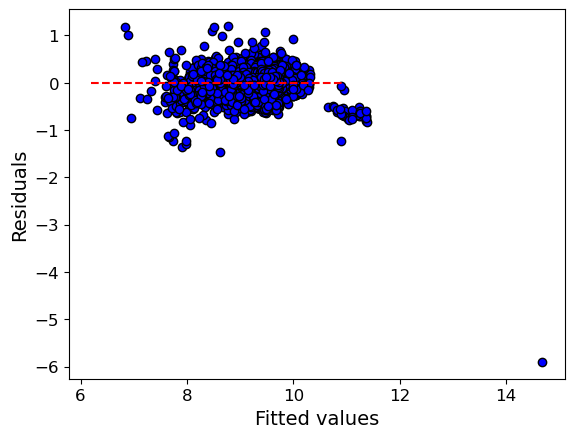

In [28]:
# Plot of residuals and fitted values
plt.scatter(x = model.fittedvalues, y = model.resid, color = 'blue', edgecolor = 'k')
xmin = min(y)
xmax = max(y)
plt.hlines(y = 0, xmin = xmin, xmax = xmax, color = 'red', linestyle = '--')
plt.xlabel('Fitted values', fontsize = 14)
plt.ylabel('Residuals', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

### Comments:
1. Most residuals are clustered near the red line, which suggests the model doesn't have bias
2. No clear pattern detected. The model isn't consistently over- or under-predicting across the range of fitted values.
3. One point has a residual around -6 with a fitted value near 14. That means the model overestimated the actual value by quite a bit.

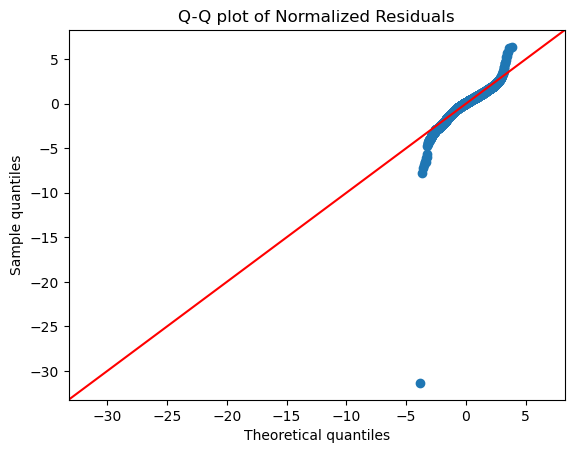

In [30]:
plt.figure(figsize = (8 ,5))
fig = smg.qqplot(data=model.resid, line = '45', fit = True)
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.title('Q-Q plot of Normalized Residuals')

plt.show()

A Q-Q plot helps assess whether residuals are normally distributed, a key assumption in linear regression.

### Comments:
1. The red reference line represents a perfectly normal distribution. Perfectly normal residuals would lie exactly on this line.

2. The blue dots represent the actual quantiles of the residuals compared to theoretical quantiles from a normal distribution. Most points hug the line, suggesting that the residuals are approximately normally distributed, and no major skewness was detected in the residuals.


<br></br>

<div style="border:2px solid #ccc; border-radius:10px; padding:20px; background:linear-gradient(to right, #f9f9f9, #e0f7fa); box-shadow:2px 2px 10px rgba(0,0,0,0.1); font-family:'Segoe UI', sans-serif;">
  <h1 style="text-align:center; color:black;">Conclusion</h1>
    
  <p style="font-size:16px; line-height:1.6; color:#333;">
    After reviewing the initial regression output, it is evident that used car prices reflect quantifiable patterns tied to car age and specifications. While a feature, like <code>tax</code>, may appear relevant in theory to explain its variations, its predictive power, nonetheless, diminishes when controlling for stronger variables. It is also notable how statistical reasoning can inform pricing strategies, consumer decisions, and policy design in this market.
  </p>

  <hr style="border:0; height:1px; background-color:#ddd; margin:20px 0;">
  <h3 style="text-align:center; color:#555;">
    Presented by:
    <a href="https://www.linkedin.com/in/carllegros/" target="_blank" style="color:#0077b6;">Carl Legros</a>
  </h3>
</div>

